In [51]:
import simpy
import numpy as np
import sys
from scipy import interpolate
from IPython.core.debugger import set_trace
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [52]:
from physiolopy.organ.organ import OrganBase2, OrganInfo, Node
from physiolopy.chemical.chemical import Compartment3, GridCompartment, Reaction3, TestTube
from physiolopy.chemical.reaction import Respiration
from physiolopy.cell import PetriDish,Bacterium,OrganismFeatures,Movement,Action

In [54]:
class Difussion(OrganBase2):
    
    def __init__(self, specie, periodo = 0.001, max_delay=1):
        super().__init__('Difussion', periodo, max_delay=max_delay)
        
        self.system=None
        self.specie = specie
        
        self.state={}
           
    def newState(self,state):
        
        #h = state['periodo'] # segs
        h = self.periodo
        time=state['time'] # Momento t-1
        
        organism = self.getOrganism()
        features = organism.getFeatures()
        x,y = features.getPosition(time)
    
        comp_in = organism.getCompartment()
        c_in = comp_in.getState(time)[self.specie]
        
        petri = organism.system
        comp_out = petri.getCompartment(x,y)
        c_out = comp_out.state[self.specie]
        
        rate = 100 * (c_out-c_in)
        var = h * rate
        
        cmp_now = comp_in.getState(self.getTimeNow())
        
        xn = cmp_now.get(self.specie,0) # inialmente contiene la concentracion en t-1 o cero si no existe
        cmp_now[self.specie] = xn + var # cada reacción incorpora su parte
        
    def getPeriodo(self):
        return self.periodo
    
    def getOrganism(self):
        return self.system
        

In [55]:
bacts = []
num = 20
#semillas = [71,32,834,182]

from random import Random
rnd = Random(3521)

for i in range(num):
    per = 0.001
    x0 = rnd.uniform(-1,1)
    y0 = rnd.uniform(-1,1)
    features=OrganismFeatures(position=(x0,y0),age=22,periodo=per)

    species={'D-Glucose':rnd.uniform(0,1)}
    cp=Compartment3(species, periodo = per)

    bact=Bacterium(features=features,compartment=cp)
    
    bact.addDifussion('Difusion1', Difussion('D-Glucose',periodo=per))

    bacts.append(bact)

<IPython.core.display.Javascript object>


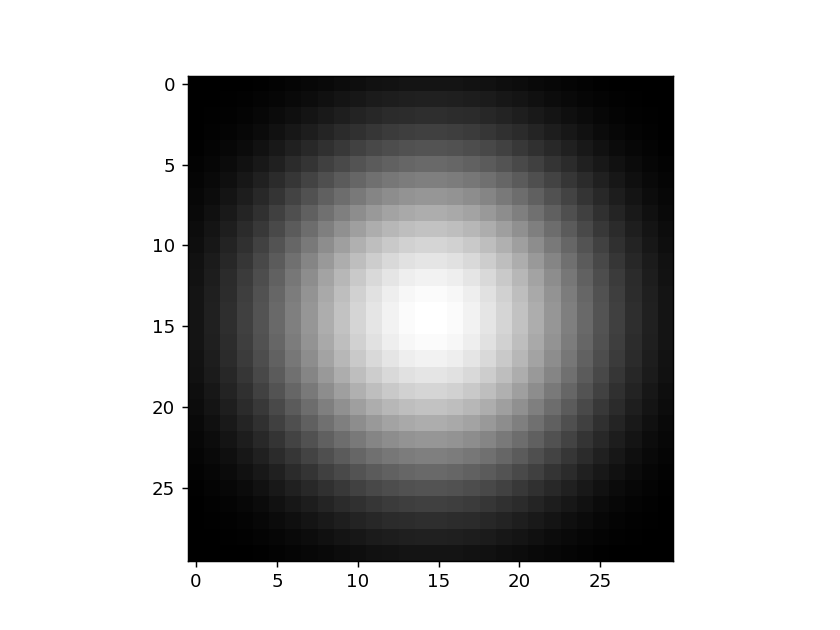

In [56]:
per = 0.001
species={'D-Glucose':1}
gcp=GridCompartment(species, bins = 30, periodo = per)

def fcp(x,y):
    from math import sin,pi
    z = (2-(x**2 + y**2)) /2
    #z1 = 0 if z<0.991 else 1
    z1 = z**4
    #z1 = sin(pi/2*z)
    return z1

gcp.setConcentration('D-Glucose',fcp)
gcp.showConcentration('D-Glucose')

In [57]:
petri = PetriDish(gcp)
for i in range(len(bacts)):
    petri.addCell(i,bacts[i])

In [58]:
env = simpy.Environment()
petri.connect(env)

env.run(until=1)


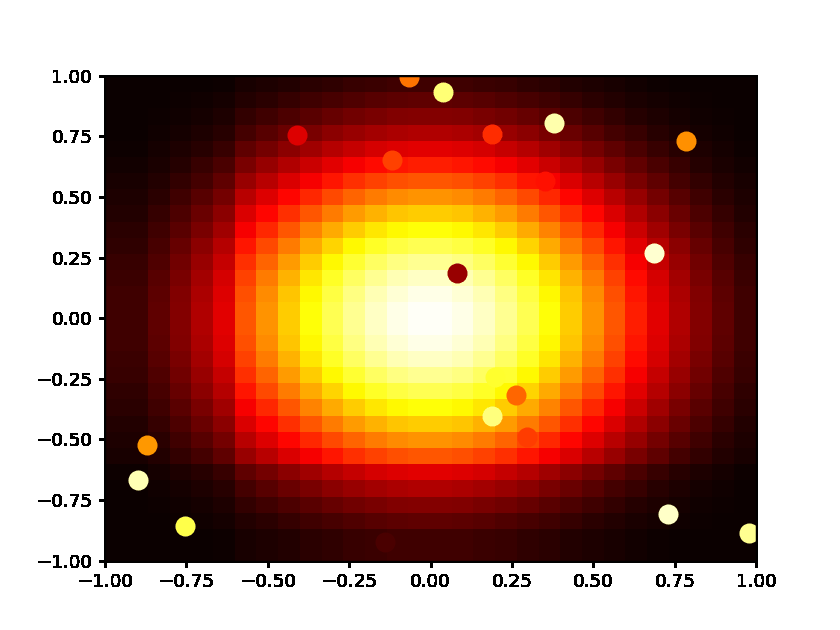

In [18]:
# Enable interactive plot
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
import matplotlib.colors as colors
import matplotlib.cm as cmx

# https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html
mapa_color = 'hot' # seismic

cm = plt.get_cmap(mapa_color)
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

num_frames = len(petri.getCell(0).getFeatures().getDataFrame())

num = gcp.getBins() + 1 
size = petri.getSize()
xl = np.linspace(-size,size,num)
yl = np.linspace(-size,size,num)
X,Y = np.meshgrid(xl,yl)
Z = np.zeros(shape=(num, num))
for (i,j) in product(range(num),range(num)):
    cp = petri.getCompartment(xl[i],yl[j])
    Z[i,j]=cp.state['D-Glucose']

z_min, z_max = -abs(Z).max(), abs(Z).max()

fig, ax = plt.subplots()
#ax.pcolormesh(X,Y,Z,vmin=-0.5, vmax = 1.0)
#ax.pcolormesh(X,Y,Z, cmap='Blues',vmin = z_min, vmax = z_max)
ax.pcolormesh(X,Y,Z, cmap=mapa_color,vmin = 0, vmax = 1)

lines = []
cells = petri.getCells()
for c in cells:
    line, = ax.plot([], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green") # A tuple unpacking to unpack the only plot
    #plt.plot(x, y, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="green")
    lines.append(line)

size = petri.getSize()
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)
#plt.set_cmap('bwr')
def animate(frame_num):
    
    pos=0
    cells = petri.getCells()
    for c in cells:
        b=cells[c]
        f=b.getFeatures()
        df=f.getDataFrame()
        spc=b.getCompartment().getDataFrame()['D-Glucose']
                     
        xx=[x for (x,y) in df['position']]
        yy=[y for (x,y) in df['position']]
        
        line = lines[pos]
        line.set_data((xx[frame_num], yy[frame_num]))
        
        #spcm= max(spc)
        #spc1 = spc[frame_num]/spcm * 5
        spc1 = spc[frame_num]
        #color = 1 if spc[frame_num-1]>0 else 1
        
        col1 = scalarMap.to_rgba(spc1)
        
        #line.set_markeredgecolor((spc1,spc1,spc1))
        #line.set_markerfacecolor((spc1,spc1,spc1))
        line.set_markeredgecolor(col1)
        line.set_markerfacecolor(col1)
        #line.set_markerfacecolor(spc1,cmap='gray',vmin = 0, vmax = 1)
        
        pos += 1
            
    return lines
    

anim = FuncAnimation(fig, animate, frames=num_frames, interval=100)